# Chapter-2 大模型使用  

本节学习大纲  

- 掌握通过 API 调用云端大模型的基本方法。  
- 掌握使用 transformers 库在本地运行大模型的基本流程。  
- 了解 vLLM 等高性能推理框架的用途和基本使用方法。

上一节课我们主要解了什么是大模型，以及在哪里可以找到它们，比如 Hugging Face Hub 以及 ModelScope。本节的主要目标是“动手”，从理论走向实践，真正地把大模型用起来。

使用大模型主要有两种路径：  

1. 云端API调用：像使用一个在线服务一样，我们发送请求，远端的服务器（云）返回结果。这种方式简单、方便，对我们自己的电脑配置要求不高。  

2. 本地化部署：把大模型下载到我们自己的电脑（服务器）上并运行起来。这种方式给了我们最大的控制权和隐私保障，但对硬件（尤其是显卡）有一定要求。

## 2.1 云端大模型调用：最便捷的路径  

这是使用大模型最直接的方式。我们不需要关心硬件配置、模型加载等复杂问题，只需要获得一个许可（API Key），然后按照服务商提供的地址和格式发送请求即可。  

我们将以[硅基流动（SiliconFlow）](https://cloud.siliconflow.cn/i/ybUFvmqK)平台为例，它提供了与 OpenAI API 完全兼容的接口，我们可以直接使用 OpenAI 中的 Python 库调用模型。  

> 注：虽然我们使用 `openai` 库的方式来调用云端大模型，但其本质是向远程服务器发送请求，所以同学们也可以使用 python 中的 `requests` 库，以发送网络请求的方式也可以实现云端大模型的调用。学有余力的同学可以自行探索一下～

### Step 1：获取 [硅基流动](https://cloud.siliconflow.cn/i/ybUFvmqK) API Key  

访问硅基流动平台官网，注册账号，在个人中心找到你的 API Key（密钥） 和 API Base URL（接口地址）。请务必保管好你的 API Key，不要泄露。  

如下图所示，创建好账户之后，即可获取到 API Key 和 API Base URL。  

![2-1 硅基流动api-key创建.png](<attachment:2-1 硅基流动api-key创建.png>)
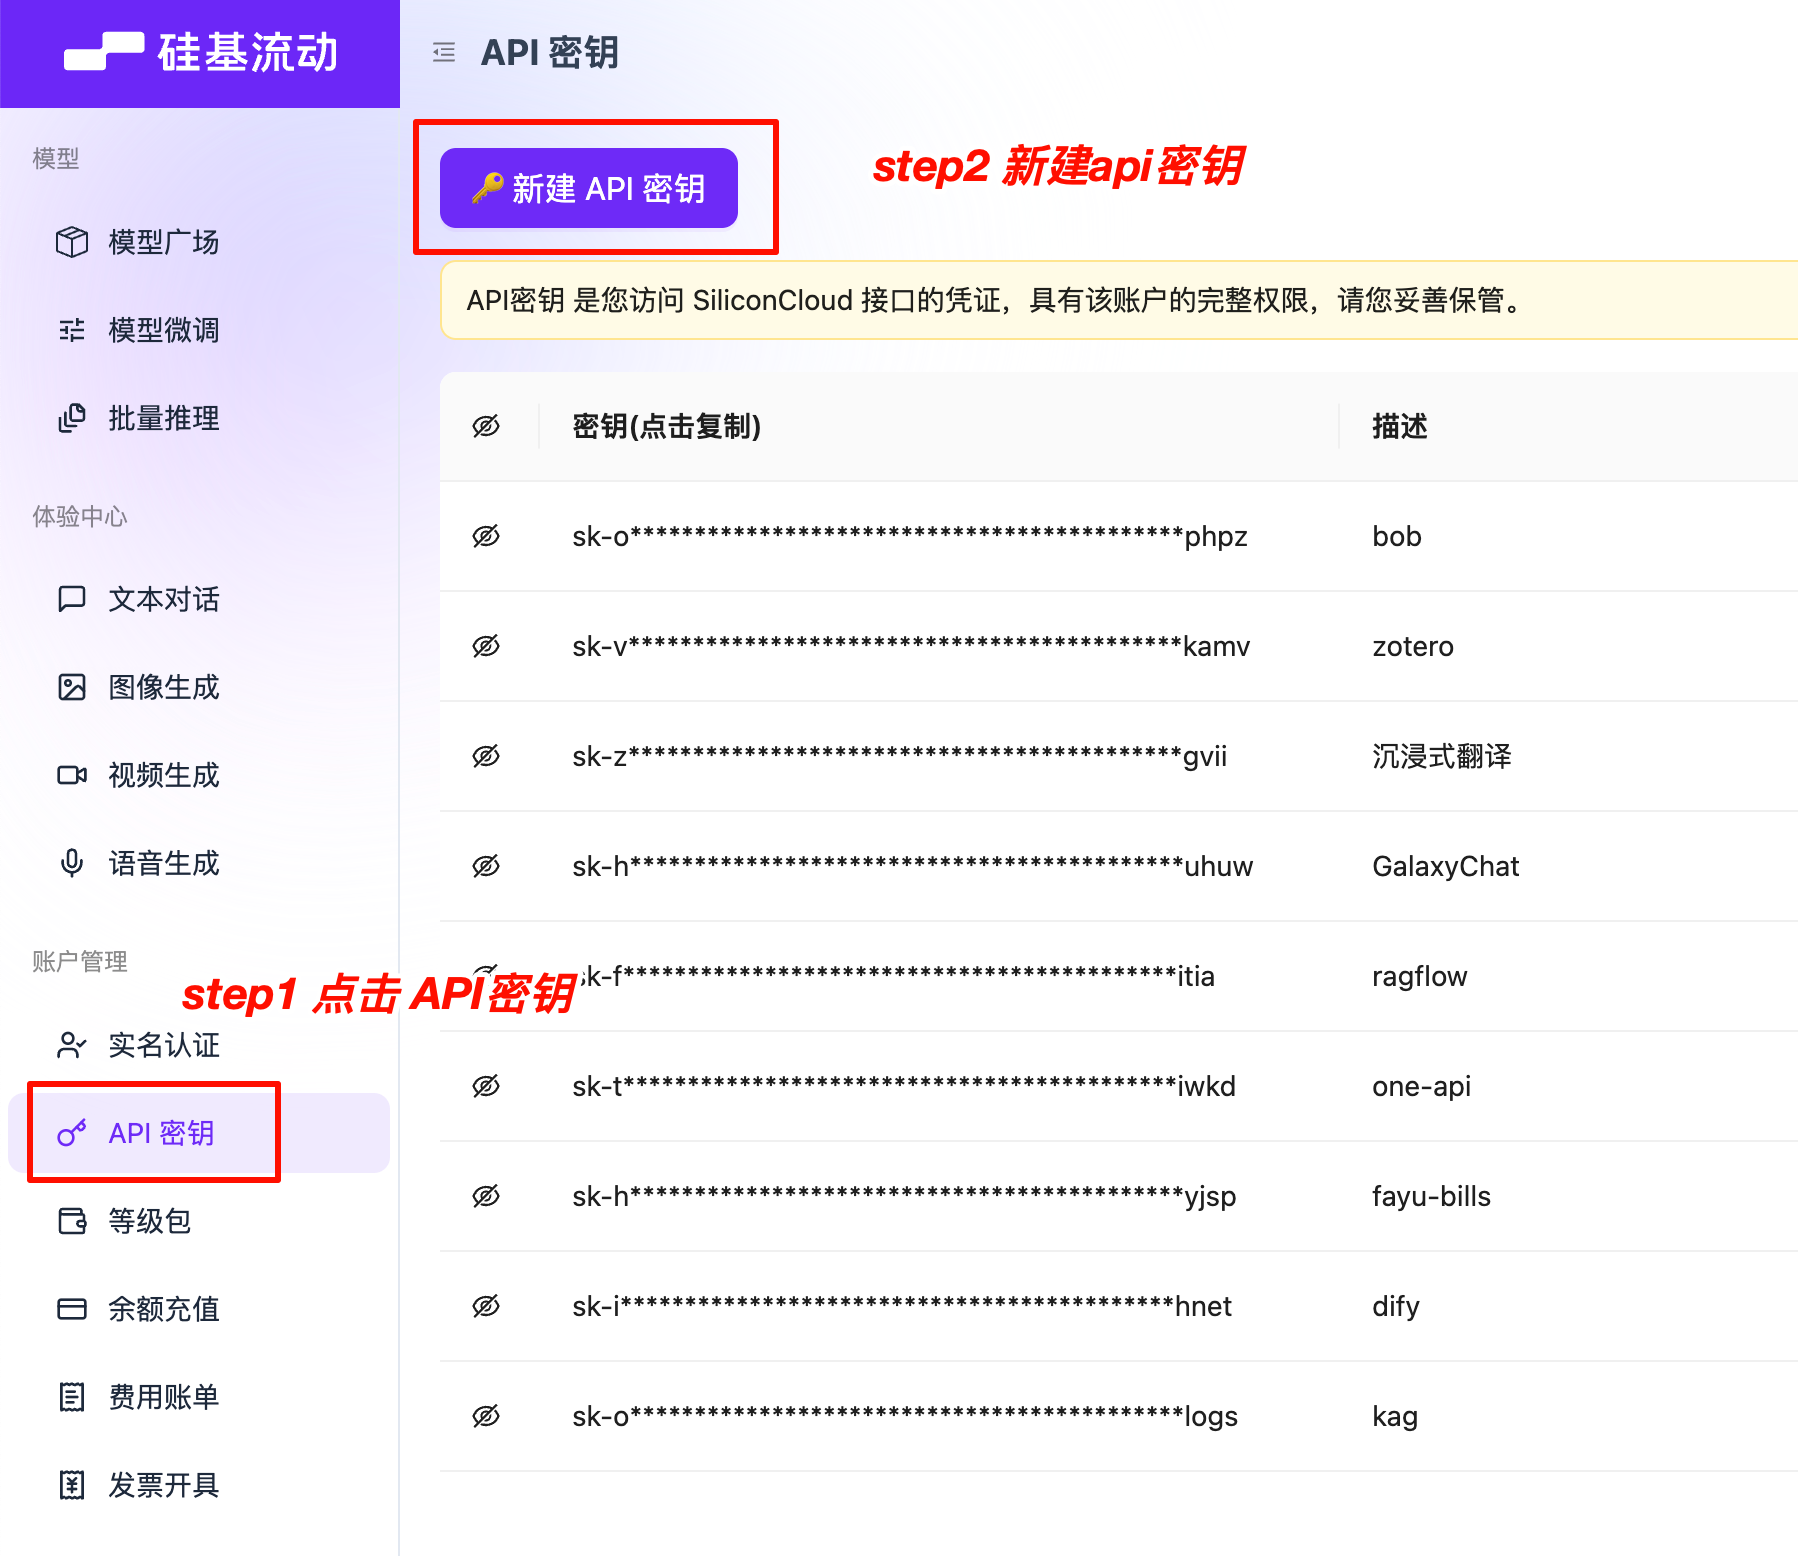

### Step 2: 调用大模型  

接下来，我们安装`openai`库，用于调用大模型。

In [ ]:
!pip config set global.index-url https://mirrors.tuna.tsinghua.edu.cn/pypi/web/simple

In [1]:
!pip install -q openai

使用以下代码调用云端API大模型：

In [ ]:
from openai import OpenAI

client = OpenAI(api_key="your api key", 
                base_url="https://api.siliconflow.cn/v1")
response = client.chat.completions.create(
    model="Qwen/Qwen3-8B",
    messages=[
        {'role': 'user', 'content': "你好！"}
    ],
    max_tokens=1024,
    temperature=0.7,
    stream=False
)
print(response.choices[0].message.content)



你好！😊 有什么我可以帮您的吗？或者您想聊些什么呢？


- temperature（温度）  
  - 控制输出的随机性/创造性  
  - 取值范围 0-1，值越大随机性越强  
  - 0表示始终选择最可能的词  

- max_tokens（最大令牌数）  
  - 限制模型回复的最大长度  
  - 1 token 约等于 4 个字符  
  - 需要根据具体任务设置合适的值  

- stream  
  - 是否流式输出  
  - 取值范围 True/False  
  - True 表示流式输出，模型会边生成边输出  
  - False 表示一次性输出全部结果

我们把以上代码封装为一个函数，可以接受用户输入，历史对话和系统提示词，最终返回模型生成的文本：

In [ ]:
def chat_with_model(user_input: str, history: list = None, temperature: float = 0.7, system_prompt: str = None) -> str:
    """
    与大模型进行对话的函数
    
    Args:
        user_input: 用户输入的文本
        history: 历史对话记录列表
        temperature: 温度参数，控制输出的随机性
        system_prompt: 系统提示词
    
    Returns:
        str: 模型返回的文本
    """

    # 初始化 OpenAI 客户端
    client = OpenAI(api_key="your api key", 
                base_url="https://api.siliconflow.cn/v1")

    # 初始化历史记录
    if history is None:
        history = []
        
    # 构建消息列表
    messages = []
    
    # 添加系统提示词(如果有)
    if system_prompt:
        messages.append({"role": "system", "content": system_prompt})
    
    # 添加历史对话
    for msg in history:
        messages.append(msg)
    
    # 添加当前用户输入
    messages.append({"role": "user", "content": user_input})
    
    # 调用API获取响应
    response = client.chat.completions.create(
        model="Qwen/Qwen3-8B",
        messages=messages,
        temperature=temperature
    )
    
    # 返回模型回复的文本
    return response.choices[0].message.content


print(chat_with_model("你好哇"))



👋😊 你好呀！今天过得怎么样呀？有什么我可以帮你的吗？


## 2.2 本地部署与调用：更强的掌控力  

调用云端的大模型固然很方便，但它存在一些问题。比如：数据的隐私性。当同学们对外发送请求的时候，本地数据已经泄漏给外界了。所以当我们用一些特殊需求时，往往会采用本地部署大模型然后进行调用。

### 2.2.1 使用 `transformers` 部署大模型  

`transformers` 是 Hugging Face 公司开发的一个库，是当下进行NLP（自然语言处理）和模型研究开发的最流行的一个python库。

> 注：不知道大家有没有完成上一节布置的课后作业？（下载 Qwen3-4B 模型）  

没有下载好的同学可以运行以下代码，在 ModelScope 平台下载模型。模型大小在 8G 左右。  

> 注：如果模型下载的环境也没有配置完全，可以再阅读以下第一节的内容，进行环境配置。

In [4]:
!pip install -q modelscope transformers accelerate

In [ ]:
from modelscope import snapshot_download

model_dir = snapshot_download('Qwen/Qwen3-4B-Instruct-2507', cache_dir='/root/autodl-tmp/model', revision='master')

模型下载完成之后，就可以使用 `transformers` 库加载模型了，首先我们需要安装一些加载模型的环境配置，如果同学们在第一节安装过了，那就不需要再安装了。  

```python  
!pip install -q modelscope transformers accelerate  
```

> 注：没有配置环境的同学，请复制以上代码到自己的环境中运行安装。  

配置好环境的同学，可以使用以下代码运行加载模型。

In [ ]:
from transformers import AutoModelForCausalLM, AutoTokenizer

# 设置模型本地路径
model_name = "/root/autodl-tmp/model/Qwen/Qwen3-4B-Instruct-2507"

# 加载分词器和模型
tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    torch_dtype="auto",  # 自动选择合适的数据类型
    device_map="cuda:0",    # 自动选择可用设备(CPU/GPU)
    trust_remote_code=True
)

# 准备模型输入
prompt = "你好，请介绍一下自己"
messages = [
    {"role": "user", "content": prompt}
]
text = tokenizer.apply_chat_template(
    messages,
    tokenize=False,
    add_generation_prompt=True,
    enable_thinking=True # 选择是否打开深度推理模式
)
# 将输入文本转换为模型可处理的张量格式
model_inputs = tokenizer([text], return_tensors="pt").to(model.device)

# 生成文本
generated_ids = model.generate(
    **model_inputs,
    max_new_tokens=32768  # 设置最大生成token数量
)
# 提取新生成的token ID
output_ids = generated_ids[0][len(model_inputs.input_ids[0]):].tolist() 

# 解析思考内容
try:
    # rindex finding 151668 (</think>)
    # 查找结束标记"</think>"的位置
    index = len(output_ids) - output_ids[::-1].index(151668)
except ValueError:
    index = 0

# 解码思考内容和最终回答
thinking_content = tokenizer.decode(output_ids[:index], skip_special_tokens=True).strip("\n")
content = tokenizer.decode(output_ids[index:], skip_special_tokens=True).strip("\n")

# 打印结果
print("thinking content:", thinking_content)
print("content:", content)

/opt/conda/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Loading checkpoint shards: 100%|██████████| 3/3 [00:02<00:00,  1.22it/s]


thinking content: <think>
嗯，用户让我介绍一下自己。首先，我需要确定用户的需求是什么。可能他们想了解我的功能、用途，或者想确认我是否适合他们的需求。用户可能是在开始对话前想先了解我的基本信息，或者他们可能对AI助手不太熟悉，需要一些引导。

接下来，我要考虑如何组织回答。用户可能希望得到一个简洁明了的介绍，涵盖我的主要功能和应用场景。同时，我需要确保回答友好且易于理解，避免使用过于技术化的术语，让不同背景的用户都能明白。

然后，我需要检查是否有遗漏的重要信息。比如，我的训练数据、支持的语言、是否支持多轮对话等。这些都是用户可能关心的点。另外，是否需要提到我的应用场景，比如回答问题、创作内容、提供建议等，这些都能帮助用户理解我的用途。

还要注意用户可能的深层需求。他们可能想知道我是否能帮助他们解决问题，或者是否适合他们的特定需求。因此，在介绍中提到我的能力范围和适用场景会很有帮助。

最后，确保回答结构清晰，分点说明，让用户一目了然。同时，保持语气友好，鼓励用户提出问题或进一步交流，以促进后续的互动。
</think>
content: 你好！我是通义千问，一个由阿里巴巴集团研发的大型语言模型，旨在帮助用户解答问题、创作内容、提供建议等。我的训练数据来自互联网文本，覆盖广泛的知识领域，能够进行多轮对话，支持多种语言（包括中文、英文、阿拉伯语、西班牙语等）。我专注于提供准确、有用的信息，并尽力满足用户的各种需求。如果你有任何问题或需要帮助，欢迎随时告诉我！


In [7]:
# 准备模型输入
prompt = "你好，请介绍一下自己"
messages = [
    {"role": "user", "content": prompt}
]
text = tokenizer.apply_chat_template(
    messages,
    tokenize=False,
    add_generation_prompt=True,
    enable_thinking=True # 选择是否打开深度推理模式
)
print(text)

<|im_start|>user
你好，请介绍一下自己<|im_end|>
<|im_start|>assistant



同样我们也可以将其封装为一个函数，如下代码所示：

In [ ]:
from transformers import AutoModelForCausalLM, AutoTokenizer

# 设置模型本地路径
model_name = "/root/autodl-tmp/model/Qwen/Qwen3-4B-Instruct-2507"

# 加载分词器和模型
tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    torch_dtype="auto",  # 自动选择合适的数据类型
    device_map="cuda:0",    # 自动选择可用设备(CPU/GPU)
    trust_remote_code=True
)
model

/opt/conda/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Loading checkpoint shards: 100%|██████████| 3/3 [00:02<00:00,  1.21it/s]


Qwen3ForCausalLM(
  (model): Qwen3Model(
    (embed_tokens): Embedding(151936, 2560)
    (layers): ModuleList(
      (0-35): 36 x Qwen3DecoderLayer(
        (self_attn): Qwen3Attention(
          (q_proj): Linear(in_features=2560, out_features=4096, bias=False)
          (k_proj): Linear(in_features=2560, out_features=1024, bias=False)
          (v_proj): Linear(in_features=2560, out_features=1024, bias=False)
          (o_proj): Linear(in_features=4096, out_features=2560, bias=False)
          (q_norm): Qwen3RMSNorm((128,), eps=1e-06)
          (k_norm): Qwen3RMSNorm((128,), eps=1e-06)
        )
        (mlp): Qwen3MLP(
          (gate_proj): Linear(in_features=2560, out_features=9728, bias=False)
          (up_proj): Linear(in_features=2560, out_features=9728, bias=False)
          (down_proj): Linear(in_features=9728, out_features=2560, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): Qwen3RMSNorm((2560,), eps=1e-06)
        (post_attention_layernorm): Qwe

In [3]:
def chat_with_local_model(model, tokenizer, user_input: str, history: list = None, temperature: float = 0.7, max_new_tokens: int = 1024, enable_thinking: bool = True) -> dict:
    """
    使用本地大模型进行对话的函数
    
    Args:
        model: 加载好的模型
        tokenizer: 加载好的分词器
        history: 历史对话记录列表，格式为 [{"role": "user", "content": "..."}, {"role": "assistant", "content": "..."}]
        temperature: 温度参数，控制输出的随机性 (0.0-1.0)
        max_new_tokens: 最大生成token数量
        enable_thinking: 是否启用深度推理模式
    
    Returns:
        dict: 包含思考内容和最终回答的字典 {"thinking_content": str, "content": str}
    """
    
    # 初始化历史记录
    if history is None:
        history = []
    
    # 构建消息列表
    messages = []
    
    # 添加历史对话
    for msg in history:
        messages.append(msg)
    
    # 添加当前用户输入
    messages.append({"role": "user", "content": user_input})
    
    # 应用聊天模板
    text = tokenizer.apply_chat_template(
        messages,
        tokenize=False,
        add_generation_prompt=True,
        enable_thinking=enable_thinking  # 选择是否打开深度推理模式
    )
    
    # 将输入文本转换为模型可处理的张量格式
    model_inputs = tokenizer([text], return_tensors="pt").to(model.device)
    
    # 生成文本
    generated_ids = model.generate(
        **model_inputs,
        max_new_tokens=max_new_tokens,  # 设置最大生成token数量
        temperature=temperature,
        do_sample=True if temperature > 0 else False  # 当temperature > 0时启用采样
    )
    
    # 提取新生成的token ID
    output_ids = generated_ids[0][len(model_inputs.input_ids[0]):].tolist()
    
    # 解析思考内容
    try:
        # rindex finding 151668 (</think>)
        # 查找结束标记"</think>"的位置
        index = len(output_ids) - output_ids[::-1].index(151668)
    except ValueError:
        index = 0
    
    # 解码思考内容和最终回答
    thinking_content = tokenizer.decode(output_ids[:index], skip_special_tokens=True).strip("\n")
    content = tokenizer.decode(output_ids[index:], skip_special_tokens=True).strip("\n")
    
    return {
        "thinking_content": thinking_content,
        "content": content
    }

# 使用示例
if __name__ == "__main__":
    
    # 单轮对话示例
    result = chat_with_local_model(
        model=model,
        tokenizer=tokenizer,
        user_input="你好，请介绍一下自己",
        temperature=0.7
    )
    
    print("\n==================== 单轮对话结果 ====================")
    print("thinking content:", result["thinking_content"])
    print("content:", result["content"])
    
    # 多轮对话示例
    history = [
        {"role": "user", "content": "你好"},
        {"role": "assistant", "content": "你好！我是Qwen，一个AI助手。"}
    ]
    
    result = chat_with_local_model(
        model=model,
        tokenizer=tokenizer,
        user_input="你能帮我写一首诗吗？",
        history=history,
        temperature=0.8
    )
    
    print("\n==================== 多轮对话结果 ====================")
    print("thinking content:", result["thinking_content"])
    print("content:", result["content"])


==================== 单轮对话结果 ====================
thinking content: <think>
好的，用户让我介绍一下自己。首先，我需要确定用户的需求是什么。可能他们想了解我的功能、用途，或者想确认我是否能帮助他们解决问题。用户可能刚接触AI助手，不太清楚我的具体能力，或者他们可能有特定的问题需要解决，想看看我是否适用。

接下来，我要考虑如何组织回答。用户可能希望得到一个简洁明了的介绍，包括我的主要功能、应用场景以及如何帮助他们。需要避免使用过于技术化的术语，保持口语化，让用户容易理解。

然后，我需要确保覆盖所有关键点：我的名称、身份、主要功能、应用场景、语言能力、学习能力、伦理原则等。同时，要突出我的优势，比如多语言支持、快速学习、伦理规范，这样用户能感受到我的可靠性和实用性。

另外，用户可能有潜在的需求，比如他们可能在寻找一个可以处理复杂任务的助手，或者需要多语言支持。因此，在介绍中要提到这些方面，让用户知道我能够满足他们的多样化需求。

还要注意回答的结构，先总述，再分点详细说明，最后邀请用户提问，这样既清晰又友好。同时，保持回答的积极态度，鼓励用户提出问题，促进进一步的互动。

最后，检查是否有遗漏的重要信息，比如是否提到我的训练数据、更新频率，或者是否支持特定的行业应用。确保回答全面，但不过于冗长，让用户能快速抓住重点。
</think>
content: 你好！我是通义千问，是阿里巴巴集团旗下的通义实验室研发的AI助手。我具备强大的语言理解和生成能力，可以进行多轮对话、回答问题、创作文本、编程、逻辑推理等多种任务。我支持多种语言，包括中文、英文、法语、西班牙语等，并且能够根据用户的需求进行学习和优化。

我的主要功能包括：
1. **信息查询**：可以回答各种问题，提供知识和信息。
2. **创作辅助**：帮助撰写文章、故事、邮件、剧本等。
3. **编程支持**：可以编写和调试代码，解释编程概念。
4. **多语言翻译**：支持多种语言的翻译和语言转换。
5. **逻辑推理**：进行数学计算、逻辑分析和问题解决。

我能够根据用户的需求进行快速学习和适应，同时遵循严格的伦理原则，确保对话的安全性和合规性。如果你有任何问题或需要帮助，欢迎随时告诉我！

====================

虽然使用 transformers 在本地部署模型能让我们获得完整的控制权限，但这种方式存在一定的性能瓶颈，尤其在首次推理时表现明显。这种本地部署方式更适合进行简单模型加载测试或算法研究工作，但若要将模型打造成一个支持高并发调用的服务，其计算效率则显得捉襟见肘。这便是 transformers 本地部署方案在性能方面的主要局限。

### 2.2.2 进阶：使用 vLLM 进行高性能部署

为了解决上述效率问题，我们可以使用像 vLLM 这样的高性能推理框架。vLLM 通过 `PagedAttention` 等先进的内存管理技术，极大地提升了模型的吞吐量（每秒能处理的请求数）和响应速度，特别是在并发请求的场景下。  

首先第一步，安装 vllm，直接安装即可～  

```python  
!pip install vllm  
```

> 注意：安装时间较长，请耐心等待。

In [1]:
!pip install -q vllm 

使用以下命令在命令行终端启动 vllm 服务：  

```bash  
vllm serve /root/autodl-tmp/model/Qwen/Qwen3-4B-Instruct-2507 \
    --served-model-name Qwen3-4B \
    --max_model_len 1024 \
    --reasoning-parser deepseek_r1 
```

以上命令中各参数的含义如下：  

- `/root/autodl-tmp/model/Qwen/Qwen3-4B-Instruct-2507`: 模型路径，指向本地存储的 Qwen 3.0 6B 模型文件  
- `--served-model-name Qwen3-4B`: 服务启动后使用的模型名称  
- `--max_model_len 1024`: 设置模型最大处理的序列长度为 1024 个 token  
- `--reasoning-parser deepseek_r1`: 使用 deepseek_r1 作为推理解析器  

这些参数配置了 vllm 服务的基本运行参数，包括模型位置、服务名称、序列长度限制以及推理相关的功能设置。  

> 注意：如果想要对 vllm 服务进行更多定制化配置，建议参考 vllm 官方文档。  

然后就可以像使用 2.1 云端大模型一样的方式来调用 vllm 启动的模型服务，如下代码所示：

In [5]:
from openai import OpenAI

client = OpenAI(api_key="xxx", 
                base_url="http://127.0.0.1:8000/v1")
response = client.chat.completions.create(
    model="Qwen3-4B",
    messages=[
        {'role': 'user', 'content': "你好哇"}
    ],
    max_tokens=512,
    temperature=0.7,
    stream=False
)
print(response.choices[0].message.content)



你好！很高兴见到你，有什么我可以帮你的吗？😊


## 课后作业  

请同学们尝试使用 python 中的 requests 来调用模型服务。

课后作业代码参考：

```python
import requests

url = "http://127.0.0.1:8000/v1/chat/completions"

payload = {
    "model": "Qwen3-4B",
    "messages": [
        {
            "role": "user",
            "content": "请详细介绍一下你自己～"
        }
    ]
}
headers = {
    "Authorization": "Bearer <token>",
    "Content-Type": "application/json"
}

response = requests.post(url, json=payload, headers=headers)

print(response.json())
```